In [68]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import os
import sys
import pandas as pd
from concave_hull import concave_hull
from shapely.geometry import Polygon, MultiPolygon
from scipy.interpolate import splprep, splev
import alphashape
from scipy.spatial import ConvexHull



racine = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(racine)

from config import chemin_tt_espace

## Connection to database

In [69]:
#Filter player and game name
joueurA = "ALEXIS-LEBRUN"
match = "ALEXIS-LEBRUN_vs_MA-LONG"


joueurA = "FAN-ZHENDONG"
match = "FAN-ZHENDONG_vs_TRULS-MOREGARD"



df = pd.read_csv(os.path.join(chemin_tt_espace,"example",match,match+"_annotation_enrichi.csv"))
df = df[df["nom"] == joueurA]
annotations = df.values.tolist()

## Strokes
This section shows statistics and displays of strokes

In [70]:
def display_density_strokes(annotations,title=''): 
    """Function used to display strike density

    Args:
        annotations (List): List of strike annotations
    """
    positions_1=[]
    positions_2=[]
    cote_jA = 81
    cote_jB = 82
    joueur_frappe = 16
    coor_frappe_x = 18
    coor_frappe_y = 19
    pos_joueur_0_x = 35
    pos_joueur_1_x = 38
    pos_joueur_0_y = 36
    pos_joueur_1_y = 39
    num_coup = 27
    for i in range(len(annotations)):
        if annotations[i][cote_jA]=='haut' and annotations[i][joueur_frappe]==joueurA: # l17 : joueur_frappe
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]), float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'haut', annotations[i][num_coup]]) #x_balle, y_balle, x_joueur, y_joueur, cote_joueur, num_coup
        elif annotations[i][cote_jA]=='bas' and annotations[i][joueur_frappe]==joueurA:
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]), float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'bas', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='haut' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]), float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'haut', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='bas' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]), float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'bas', annotations[i][num_coup]])


    im_table_env=Image.open(os.path.join(chemin_tt_espace,"images","utils","environnement_demie_table.png")).convert('RGB')
    W_im_env, h_im_env=im_table_env.size

    #size=10
    R=25

    im_table_env_densite_jA=im_table_env.copy()
    px_table_env_jA=im_table_env_densite_jA.load()
    g=255
    b=255
    
    for i in range(len(positions_1)):
        if positions_1[i][4]=='bas':
            x_jA=positions_1[i][2]+W_im_env/2
            y_jA=-positions_1[i][3]     
        elif positions_1[i][4]=='haut':
            x_jA=-positions_1[i][2]+W_im_env/2
            y_jA=positions_1[i][3]
        
        for l in range(2*R):
            for L in range(2*R):
                if (L-R)**2+(l-R)**2<R**2:
                    if x_jA+L-R<W_im_env and y_jA+l-R<h_im_env and x_jA+L-R>0 and y_jA+l-R>0:
                        g=int(px_table_env_jA[x_jA+L-R,y_jA+l-R][1]-18)
                        b=int(px_table_env_jA[x_jA+L-R,y_jA+l-R][2]-18)
                        if g>0 and b>0:
                            im_table_env_densite_jA.putpixel([int(x_jA+L-R),int(y_jA+l-R)],(int(255),g,b))
                            px_table_env_jA=im_table_env_densite_jA.load()

    plt.imshow(im_table_env_densite_jA)
    plt.axis('off')
    plt.title(title)

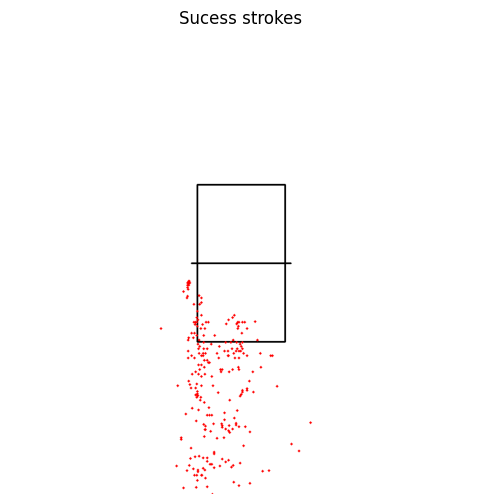

In [71]:
def display_strokes(annotations, save=False, title='', ax=None): 
    """Affiche la position des frappes sur une image

    Args:
        annotations (List): Liste des annotations
        save (bool): Enregistrer l'image ?
        title (str): Titre du graphique
        ax (matplotlib.axes.Axes): Axe matplotlib sur lequel afficher (optionnel)
    """
    positions_1=[]
    positions_2=[]
    cote_jA = 81
    cote_jB = 82
    joueur_frappe = 16
    coor_frappe_x = 18
    coor_frappe_y = 19
    pos_joueur_0_x = 35
    pos_joueur_1_x = 38
    pos_joueur_0_y = 36
    pos_joueur_1_y = 39
    num_coup = 27

    for i in range(len(annotations)):
        if annotations[i][cote_jA]=='haut' and annotations[i][joueur_frappe]==joueurA:
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'haut', annotations[i][num_coup]])
        elif annotations[i][cote_jA]=='bas' and annotations[i][joueur_frappe]==joueurA:
            positions_1.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_0_x]),-float(annotations[i][pos_joueur_0_y]),'bas', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='haut' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'haut', annotations[i][num_coup]])
        elif annotations[i][cote_jB]=='bas' and annotations[i][joueur_frappe]!=joueurA:
            positions_2.append([float(annotations[i][coor_frappe_x]),-float(annotations[i][coor_frappe_y]),float(annotations[i][pos_joueur_1_x]),-float(annotations[i][pos_joueur_1_y]),'bas', annotations[i][num_coup]])

    w, h = 800, 800
    image = np.ones((h, w, 3), dtype=np.uint8) * 255  

    cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400-152/2), int(400-272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400+152/2), int(400-272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400+152/2), int(400+272/2)), (int(400-152/2), int(400+272/2)), (0, 0, 0), 2)
    cv2.line(image, (int(400-152/2-10), int(400)), (int(400+152/2+10), int(400)), (0, 0, 0), 2)
    
            
    for pos in positions_1:
        if pos[4]=='bas':
            x = pos[2] + w/2
            y = -pos[3] + 400    
        elif pos[4]=='haut':
            x = -pos[2] + w/2
            y = pos[3] + 400
        cv2.circle(image, (int(x), int(y)), 2, (255,0,0), -1)

    if save:
        cv2.imwrite("../frappe_rapport_table.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if ax is None:
        plt.figure(figsize=(6,6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)
        plt.show()
    else:
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(title)
display_strokes(annotations, title='Sucess strokes')

### Strike positions

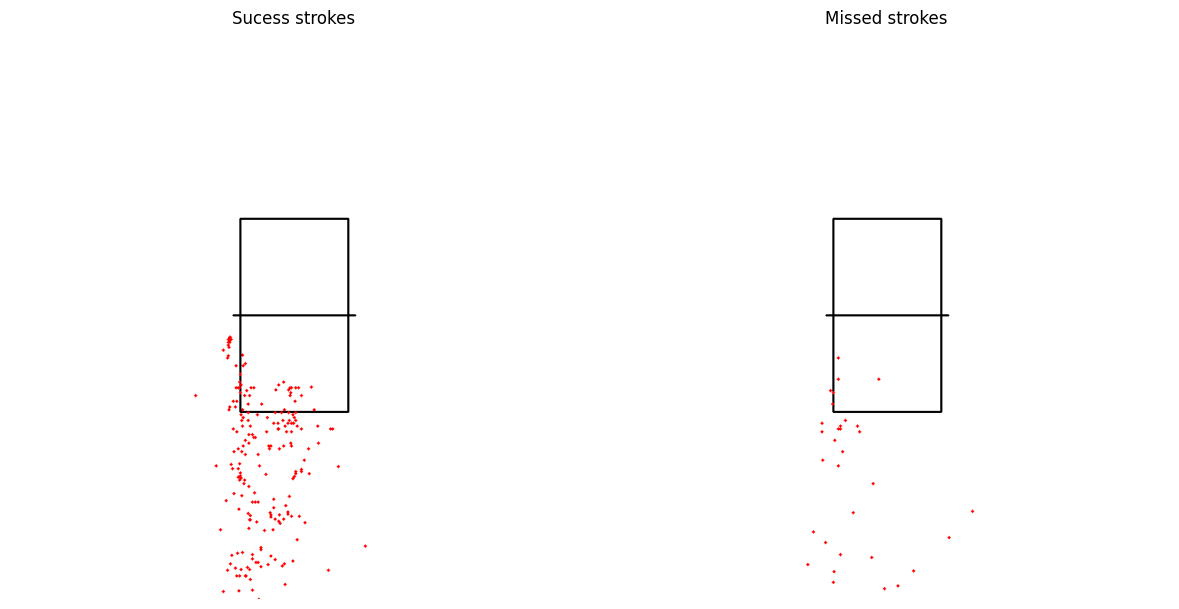

In [72]:
#All success strokes
#df = pd.read_sql_query(requete, con)
annotations_frappes_reussies = df[df["coor_balle_x"].notna()].values.tolist()
#All missed strokes
#df = pd.read_sql_query(requete, con)
annotations_frappes_fautes = df[df["coor_balle_x"].isna()].values.tolist()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))

display_strokes(annotations_frappes_reussies, title='Sucess strokes', ax=axs[0])
display_strokes(annotations_frappes_fautes, title='Missed strokes', ax=axs[1])

plt.tight_layout()
plt.show()


### Display the position of the shot relative to the player's position
The color represents the type of stroke:
- Blue: backhand
- Red: forehand

(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

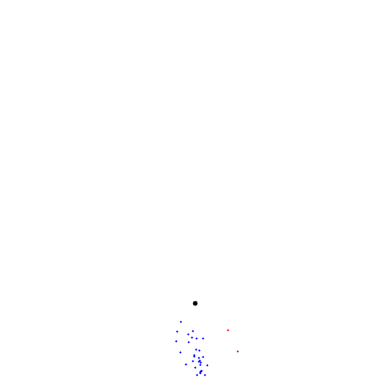

In [86]:
w,h = 800, 800
size=5


image = np.ones((h, w, 3), dtype=np.uint8) * 255  
set_point=[] # num set, num pt
set_point.append([1,0])
for i in range(2,len(annotations)):
    if annotations[i][52]!=annotations[i-1][52]:
        set_point.append([int(annotations[i][5]), int(annotations[i][52])])

coord=[] #xj, yj, xb, yb


set_point_annotation = annotations

time_frappe=[] #frame de frappe (sachant que les num de frame reviennent à 0 à chaque début de point dans les clips)

for j in range(len(set_point_annotation)):
    #print(set_point_annotation[j])
    pos_joueur_0_frappe_y = 70
    pos_joueur_0_frappe_x = 69
    coor_frappe_y = 19
    coor_frappe_x = 18
    pos_joueur_1_frappe_y = 73
    pos_joueur_1_frappe_x = 72
    lateralite = 4
    effet_coup = 12
    winner = 28
    num_point = 53
    num_coup = 27
    num_set = 5
    debut = 1
    if float(set_point_annotation[j][pos_joueur_0_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 : # ie j0 et balle du même côté de la table
        if -float(set_point_annotation[j][coor_frappe_y]) > 0 : # et du côté des y positifs
            coord.append([-float(set_point_annotation[j][pos_joueur_0_frappe_x]), float(set_point_annotation[j][pos_joueur_0_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_0_frappe_x]), -float(set_point_annotation[j][pos_joueur_0_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    elif float(set_point_annotation[j][pos_joueur_1_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 :
        if -float(set_point_annotation[j][coor_frappe_y]) >0 :
            coord.append([-float(set_point_annotation[j][pos_joueur_1_frappe_x]), float(set_point_annotation[j][pos_joueur_1_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_1_frappe_x]), -float(set_point_annotation[j][pos_joueur_1_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    

deplacement_x = 0
deplacement_y = int(272/2+100)
cv2.circle(image, (w//2+deplacement_x, h//2+deplacement_y), 5, (0,0,0), -1)

atteintes = []
for i in range(len(coord)):
    atteintes.append([float(coord[i][2]-coord[i][0]), abs(float(coord[i][3]-coord[i][1])),coord[i][4],coord[i][5],coord[i][6],coord[i][7],coord[i][8],coord[i][9]])
    if atteintes[i][6] != 1 and (atteintes[i][7] == 1 or atteintes[i][7] == 3) and atteintes[i][3] == "topspin":
        

        if coord[i][4] == "revers":
            couleur = (0,0,255)
        else:
            couleur = (255,0,0)
        #couleur = (255,0,0)
        cv2.circle(image, (int(coord[i][2]-coord[i][0])+w//2+deplacement_x, -int(coord[i][3]-coord[i][1])+h//2+deplacement_y), 2, couleur, -1)

cv2.imwrite(os.path.join(chemin_tt_espace,"images","1_stats_bdd","frappe_rapport_joueur.jpg"), image)


plt.imshow(image)
plt.axis('off')

### Strike density

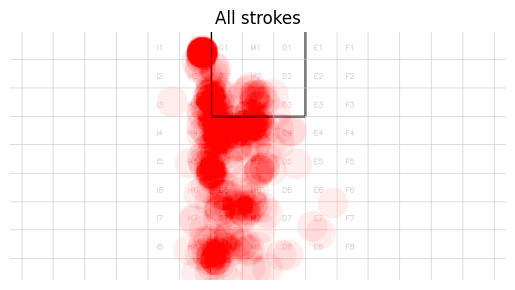

In [74]:
display_density_strokes(annotations,"All strokes")

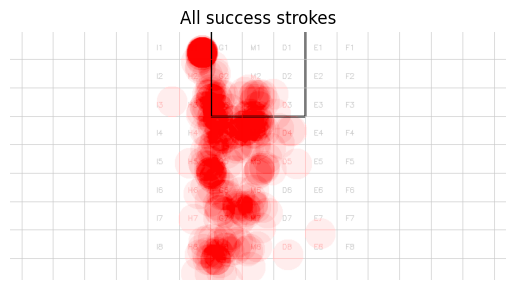

In [75]:

annotations_frappes_reussies = df[df["coor_balle_x"].notna()].values.tolist()

display_density_strokes(annotations_frappes_reussies,"All success strokes")

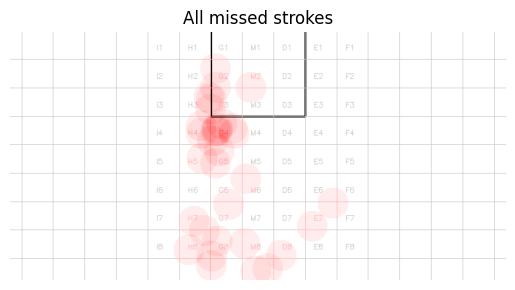

In [76]:

annotations_frappes_rates = df[df["coor_balle_x"].isna()].values.tolist()

display_density_strokes(annotations_frappes_rates,"All missed strokes")

### Reached balls

In [77]:
df_qualite = pd.read_csv(os.path.join(chemin_tt_espace,"example",match,match+"_annotation_qualite.csv"))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


(np.float64(-0.5), np.float64(799.5), np.float64(799.5), np.float64(-0.5))

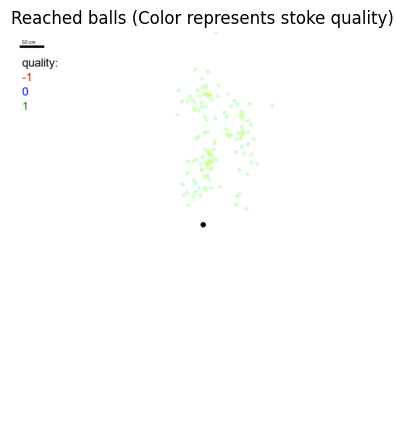

In [ ]:
height, width = 800, 800
size=5
image_jA=np.ones((height, width,3), np.uint8)*255
image_jA=Image.fromarray(image_jA)
image_jB=image_jA.copy()
draw_jA = ImageDraw.Draw(image_jA)
draw_jB = ImageDraw.Draw(image_jB)
xj, yj = width/2, height/2
draw_jA.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")
draw_jB.ellipse((xj - size, yj - size, xj + size, yj + size), fill="black")

set_point=[] # num set, num pt
set_point.append([1,0])
for i in range(2,len(annotations)):
    if annotations[i][52]!=annotations[i-1][52]:
        set_point.append([int(annotations[i][5]), int(annotations[i][52])])

coord=[] #xj, yj, xb, yb


set_point_annotation = annotations

time_frappe=[] 

for j in range(len(set_point_annotation)):
    pos_joueur_0_frappe_y = 70
    pos_joueur_0_frappe_x = 69
    coor_frappe_y = 19
    coor_frappe_x = 18
    pos_joueur_1_frappe_y = 73
    pos_joueur_1_frappe_x = 72
    lateralite = 4
    effet_coup = 12
    winner = 28
    num_point = 53
    num_coup = 27
    num_set = 5
    debut = 1
    if float(set_point_annotation[j][pos_joueur_0_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 :
        if -float(set_point_annotation[j][coor_frappe_y]) >0 :
            coord.append([-float(set_point_annotation[j][pos_joueur_0_frappe_x]), float(set_point_annotation[j][pos_joueur_0_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_0_frappe_x]), -float(set_point_annotation[j][pos_joueur_0_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    elif float(set_point_annotation[j][pos_joueur_1_frappe_y]) * float(set_point_annotation[j][coor_frappe_y]) >0 :
        if -float(set_point_annotation[j][coor_frappe_y]) >0 :
            coord.append([-float(set_point_annotation[j][pos_joueur_1_frappe_x]), float(set_point_annotation[j][pos_joueur_1_frappe_y]), -float(set_point_annotation[j][coor_frappe_x]), float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
        elif -float(set_point_annotation[j][coor_frappe_y]) <0 :
            coord.append([float(set_point_annotation[j][pos_joueur_1_frappe_x]), -float(set_point_annotation[j][pos_joueur_1_frappe_y]), float(set_point_annotation[j][coor_frappe_x]), -float(set_point_annotation[j][coor_frappe_y]),set_point_annotation[j][lateralite],set_point_annotation[j][effet_coup],set_point_annotation[j][winner],set_point_annotation[j][num_point],set_point_annotation[j][num_coup],set_point_annotation[j][num_set],set_point_annotation[j][debut]])
    

qualite_coup_liste = df_qualite["qualite_coup"].tolist()

atteintes = []
for i in range(len(coord)):
    atteintes.append([float(coord[i][2]-coord[i][0]), abs(float(coord[i][3]-coord[i][1])),coord[i][4],coord[i][5],coord[i][6],coord[i][7],coord[i][8],coord[i][9],df_qualite[(df_qualite["debut"] == coord[i][10])]["qualite_coup"].iloc[0]])

im=image_jA.copy()
px=im.load()

R=5
liste_derriere = []
for i in range(len(atteintes)):
    xb, yb = atteintes[i][0] +xj, -atteintes[i][1] +yj
    if yb > yj and atteintes[i][6] != 1:
        #print(atteintes[i][5],atteintes[i][6])
        liste_derriere.append([atteintes[i][5],atteintes[i][6]])
    for l in range(2*R):
        for L in range(2*R):
            if (L-R)**2+(l-R)**2<R**2:
                if xb+L-R<width and yb+l-R<height and xb+L-R>0 and yb+l-R>0:
                    g=int(px[xb+L-R,yb+l-R][1]-40)
                    b=int(px[xb+L-R,yb+l-R][2]-40)
                    if g>0 and b>0 and atteintes[i][6] != 1 and (atteintes[i][7] != 1 or atteintes[i][7] != 13) and atteintes[i][3] == "topspin":# and atteintes[i][5] == 33 and atteintes[i][6] == 5: 

                        if atteintes[i][8] == -1:
                            couleur = (255,g,b)
                        elif atteintes[i][8] == 0:
                            couleur = (g,b,255)
                        else:
                            couleur = (g,255,b)
                        im.putpixel([int(xb+L-R),int(yb+l-R)],couleur)
                        px=im.load()
    draw=ImageDraw.Draw(im)
draw.line([(20,30),(70,30)], fill='black', width=5)
draw.text((25,15), '50 cm', fill='black')
    #im.save('output/match_{}/nuage/nuage_{}.png'.format(match, i))




font = ImageFont.truetype("arial.ttf", size=24)
draw.text((25,50), 'quality:', fill='black', font=font)
draw.text((25,80), '-1', fill='red', font=font)
draw.text((25,110), '0', fill='blue', font=font)
draw.text((25,140), '1', fill='green', font=font)
plt.figure(figsize=(10,5))
plt.imshow(im)
plt.title('Reached balls (Color represents stoke quality)')
plt.axis('off')

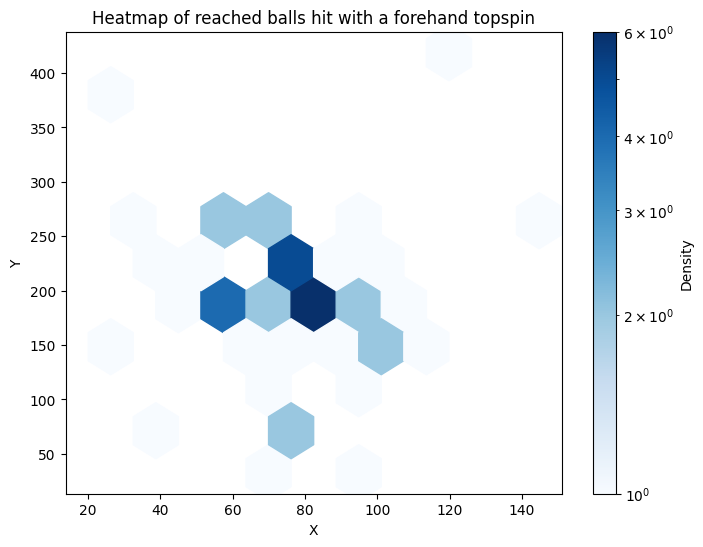

In [87]:

atteintes_filtre = []
for i in range(len(atteintes)):
    if atteintes[i][6] != 1 and  atteintes[i][3] == "topspin" and  atteintes[i][2] == "coup_droit":
        atteintes_filtre.append(atteintes[i])

x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]

plt.figure(figsize=(8, 6))
plt.hexbin(x, y, gridsize=10, cmap='Blues', bins='log')

plt.colorbar(label="Density")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Heatmap of reached balls hit with a forehand topspin")

plt.show()


### convex envelope

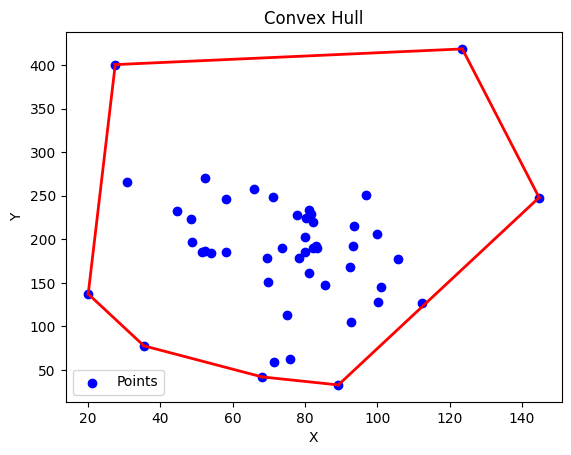

In [88]:


np.random.seed(42)
points = np.random.rand(30, 2) * 10 
points = np.array([[x[i],y[i]] for i in range(len(x))])


hull = ConvexHull(points)
hull_points = points[hull.vertices]

df_enveloppe = pd.DataFrame(hull_points, columns=["X", "Y"])

if not os.path.isdir(os.path.join(chemin_tt_espace,"example",match,"1_stats_bdd")):
    os.mkdir(os.path.join(chemin_tt_espace,"example",match,"1_stats_bdd"))

df_enveloppe.to_csv(os.path.join(chemin_tt_espace,"example",match,"1_stats_bdd","enveloppe_convexe.csv"), index=False)


plt.scatter(points[:, 0], points[:, 1], label="Points", color="blue")

for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], "r-", linewidth=2)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Convex Hull")
plt.legend()
plt.show()


### Save players' convex envelopes 
Save envelopes in function of type of strokes

In [96]:

if not os.path.isdir(os.path.join(chemin_tt_espace,"example",match,"enveloppe")):
    os.mkdir(os.path.join(chemin_tt_espace,"example",match,"enveloppe"))
atteintes_filtre = []
for i in range(len(atteintes)):
    if atteintes[i][6] != 1:
        atteintes_filtre.append(atteintes[i])

x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]


points = np.random.rand(30, 2) * 10  # 30 points dans un carré de 10x10
points = np.array([[x[i],y[i]] for i in range(len(x))])

hull = ConvexHull(points)
hull_points = points[hull.vertices]

df_enveloppe = pd.DataFrame(hull_points, columns=["X", "Y"])

df_enveloppe.to_csv(os.path.join(chemin_tt_espace,"example",match,"enveloppe",match+"_"+joueurA+"_tous_enveloppe.csv"), index=False)


for qualite in [0,1,-1]:
    for coup in ['coup_droit','revers']:
        for effet in ['topspin',"bloc","poussette","flip"]:
            atteintes_filtre = []
            for i in range(len(atteintes)):
                if atteintes[i][6] != 1 and  atteintes[i][3] == effet and  atteintes[i][2] == coup and atteintes[i][8] == qualite:
                    atteintes_filtre.append(atteintes[i])
            if len(atteintes_filtre) >3:
                x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
                y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]


                points = np.random.rand(30, 2) * 10
                points = np.array([[x[i],y[i]] for i in range(len(x))])
                if len(points) > 3:
                    hull = ConvexHull(points)
                    hull_points = points[hull.vertices]
                    print(hull_points)
                    print(qualite,effet,coup)
                    print("eeeeeeeee")
                    df_enveloppe = pd.DataFrame(hull_points, columns=["X", "Y"])
                    if qualite == -1:
                        qualite = "nulle"
                    df_enveloppe.to_csv(os.path.join(chemin_tt_espace,"example",match,"enveloppe",match+"_"+joueurA+"_"+coup+"_"+effet+"_"+"qualite_"+str(qualite)+"_enveloppe.csv"), index=False)



for coup in ['coup_droit','revers']:
    for effet in ['topspin',"bloc","poussette","flip"]:
        atteintes_filtre = []
        for i in range(len(atteintes)):
            if atteintes[i][6] != 1 and  atteintes[i][3] == effet and  atteintes[i][2] == coup:
                atteintes_filtre.append(atteintes[i])

        x = [atteintes_filtre[i][0] for i in range(len(atteintes_filtre))]
        y = [atteintes_filtre[i][1] for i in range(len(atteintes_filtre))]


        points = np.random.rand(30, 2) * 10 
        points = np.array([[x[i],y[i]] for i in range(len(x))])
        if len(points) > 3:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]

            df_enveloppe = pd.DataFrame(hull_points, columns=["X", "Y"])

            df_enveloppe.to_csv(os.path.join(chemin_tt_espace,"example",match,"enveloppe",match+"_"+joueurA+"_"+coup+"_"+effet+"_enveloppe.csv"), index=False)


[[144.72082579 247.96843417]
 [123.50892243 418.71324823]
 [ 27.58404571 400.7006717 ]
 [ 20.11259423 137.19115017]
 [ 35.51038543  77.61124361]
 [ 68.1312874   41.9131821 ]
 [ 89.23937072  32.68475961]]
1 topspin coup_droit
eeeeeeeee
[[ 98.95448532 224.96265345]
 [ 16.03592868 203.49352854]
 [112.15045895  90.43345087]
 [115.78267929 122.89807079]
 [106.37934267 195.22583845]]
1 bloc coup_droit
eeeeeeeee
[[131.67359033  22.32195492]
 [ 71.06627318 277.71817836]
 [ 40.71424876 258.92235363]
 [ 21.59559651 161.54588238]
 [ 23.49035727  51.53231001]
 [ 37.03847274  35.38197824]
 [ 60.20058592  23.6682091 ]]
1 poussette coup_droit
eeeeeeeee
[[-52.00988408 227.61003836]
 [-41.45981408  82.67164019]
 [-39.00529732  61.92040346]
 [-31.03481332  40.29474187]
 [ 17.02298936  76.53856988]
 [ 26.28475888 134.480557  ]
 [ 32.16084938 289.57280794]
 [  9.6234902  317.92396145]
 [-16.41961768 322.02146386]
 [-50.56045034 278.52391108]]
1 topspin revers
eeeeeeeee
[[-17.36391384 252.93352931]
 [-33.7

In [97]:
width, height = 800, 800

image = np.ones((height, width, 3), dtype=np.uint8) * 255

coup = "coup_droit"
effet = "topspin"
df_enveloppe = pd.read_csv(os.path.join(chemin_tt_espace,"example",match,"enveloppe",match+"_"+joueurA+"_"+coup+"_"+effet+"_enveloppe.csv"))
print(df_enveloppe)
df_enveloppe["X"] += width//2
df_enveloppe["Y"] = -df_enveloppe["Y"]
df_enveloppe["Y"] += height//2
points = df_enveloppe[['X', 'Y']].values.astype(np.int32)


hull = ConvexHull(points)
hull_points = points[hull.vertices]

hull_pts_cv2 = hull_points.reshape((-1, 1, 2))

cv2.fillPoly(image, [hull_pts_cv2], (255, 150, 150))

cv2.imwrite(os.path.join(chemin_tt_espace,"example",match,"enveloppe.png"), image)

            X           Y
0  144.720826  247.968434
1  123.508922  418.713248
2   27.584046  400.700672
3   20.112594  137.191150
4   35.510385   77.611244
5   68.131287   41.913182
6   89.239371   32.684760


True

### Concave envelope

In [98]:
balles_frappees_jA, balles_frappees_jB = [], []
for i in range(len(atteintes)):
    if atteintes[i][6] != 1:
        balles_frappees_jA.append(np.array([atteintes[i][0]+xj, atteintes[i][1]+yj]))
balles_frappees_jA=np.array(balles_frappees_jA)

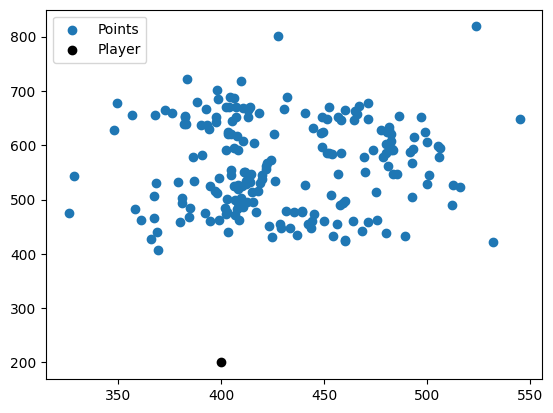

In [99]:
# méthod 1 : concave_hull

hull_points_jA=concave_hull(balles_frappees_jA)

plt.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], label='Points')
plt.scatter(400,200, color='k', label='Player')
plt.legend()
plt.show()

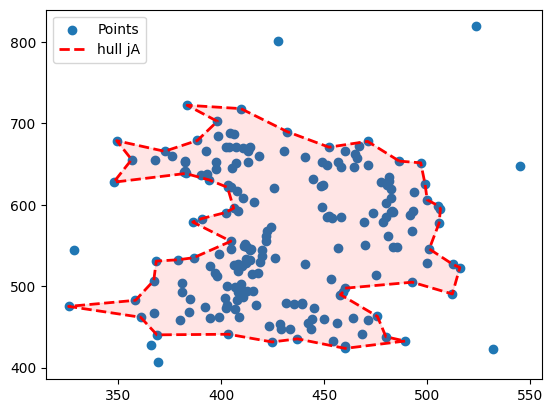

In [100]:
# Method 2 : alphashape

alpha = 0.053
hull_points_jA = alphashape.alphashape(balles_frappees_jA, alpha)

def plot_polygon(ax, polygon, color='r', alpha=0.1):
    if isinstance(polygon, Polygon):
        hull_points = np.array(polygon.exterior.coords)
        ax.plot(hull_points[:, 0], hull_points[:, 1], 'r--', lw=2, label='hull jA')
        ax.fill(hull_points[:, 0], hull_points[:, 1], color=color, alpha=0.1)
    elif isinstance(polygon, MultiPolygon):
        for poly in polygon.geoms:
            plot_polygon(ax, poly, color, alpha)

fig, ax = plt.subplots()
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], label='Points')
plot_polygon(ax, hull_points_jA)
ax.legend()
plt.show()

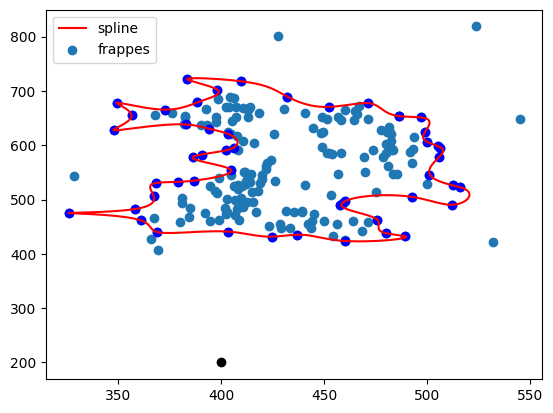

In [101]:
# Method 2 advanced : spline smoothing

contour_points_liste = []
if isinstance(hull_points_jA, Polygon):
    contour_points_liste.append(np.array(hull_points_jA.exterior.coords))
elif isinstance(hull_points_jA, MultiPolygon):
    for poly in hull_points_jA.geoms:
        contour_points_liste.append(np.array(poly.exterior.coords))

x, y = [], []
for contour_points in contour_points_liste:
    tck, u = splprep([contour_points[:, 0], contour_points[:, 1]], s=2.0, per=True)
    u_nouv = np.linspace(u.min(), u.max(), 1000)
    x_nouv, y_nouv = splev(u_nouv, tck)
    x.append(x_nouv)
    y.append(y_nouv)

fig,ax=plt.subplots()
for contour_points in contour_points_liste:
    plt.plot(contour_points[:, 0], contour_points[:, 1], 'o', color='blue')
for x_nouv, y_nouv in zip(x, y):
    plt.plot(x_nouv, y_nouv, '-', label='spline', color='red')
ax.scatter(balles_frappees_jA[:, 0], balles_frappees_jA[:, 1], color='tab:blue', label='frappes')
ax.scatter(400,200,color='k')
plt.legend()
plt.show()

### Statistics

Section presenting the various statistics related to strikes

In [102]:
print("Number of strokes played by " + joueurA + " :" + str(len(df)))
print("Number of strokes played by " + joueurA + ", on the table:" + str(len(df[df["coor_balle_x"].notna()])))
print("Number of strokes played by " + joueurA + ", fault:" + str(len(df[df["coor_balle_x"].isna()])))


Number of strokes played by FAN-ZHENDONG :254
Number of strokes played by FAN-ZHENDONG, on the table:222
Number of strokes played by FAN-ZHENDONG, fault:32


Strokes quality statistics

In [103]:

print("Number of strokes played by " + joueurA + " quality -1: "+ str(len(df_qualite[(df_qualite["nom"] == joueurA) & (df_qualite["qualite_coup"] == -1)])))
print("Number of strokes played by " + joueurA + " quality 0: "+ str(len(df_qualite[(df_qualite["nom"] == joueurA) & (df_qualite["qualite_coup"] == 0)])))
print("Number of strokes played by " + joueurA + " quality 1: "+ str(len(df_qualite[(df_qualite["nom"] == joueurA) & (df_qualite["qualite_coup"] == 1)])))


print("Number of strokes played by " + joueurA + " opponent quality -1: "+ str(len(df_qualite[(df_qualite["nom"] != joueurA) & (df_qualite["qualite_coup"] == -1)])))
print("Number of strokes played by " + joueurA + " opponent quality 0: "+ str(len(df_qualite[(df_qualite["nom"] != joueurA) & (df_qualite["qualite_coup"] == 0)])))
print("Number of strokes played by " + joueurA + " opponent quality 1: "+ str(len(df_qualite[(df_qualite["nom"] != joueurA) & (df_qualite["qualite_coup"] == 1)])))

Number of strokes played by FAN-ZHENDONG quality -1: 0
Number of strokes played by FAN-ZHENDONG quality 0: 0
Number of strokes played by FAN-ZHENDONG quality 1: 254
Number of strokes played by FAN-ZHENDONG opponent quality -1: 0
Number of strokes played by FAN-ZHENDONG opponent quality 0: 0
Number of strokes played by FAN-ZHENDONG opponent quality 1: 258
